In [1]:
import re
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
node = []
allDatas = []
siganlList = []
SignalsName = []
messageName = []

In [2]:
def readFile(file_name):
    global node,allDatas,siganlList,SignalsName,messageName
    ''' 得到dbc文件的绝对路径'''
    filePath = file_name
    if filePath:
        print(filePath)
        f = open(filePath, "r")  # 设置文件对象
    else:
        print("读取文件失败！")
        return 0
    """
    NodesPattern:节点
    MessagePattern：消息
    SignalPattern：信号
    """
    NodesPattern = re.compile(r"BU_: (.*)", re.S)
    MessagePattern = re.compile(r"BO_ (.*?) (.*?): (.*?) (.*)", re.S)
#     SignalPattern = re.compile('''SG_ (.*?) : (.*?)\|(.*?)@.*? \((.*?),(.*?)\) \[(.*?)\|(.*?)\] "(.*?)" (.*)''', re.S)
    SignalPattern = re.compile('''SG_ (.*?) : (.*?)\|(.*?)@([0-9])([+|-]) \((.*?),(.*?)\) \[(.*?)\|(.*?)\] "(.*?)" (.*)''', re.S)
    DefaultValue = '''BA_ "GenSig(.*?)" SG_ (\d+) signalname (\d+);'''

    line = f.readline()
    allDatas=[]
    while line:
        """ 匹配出节点 """
        NodesSearched = re.search(NodesPattern, line.strip())
        if NodesSearched:
            node = NodesSearched.group(1).split(" ")
            #print(node)
        """ 匹配出消息 """
        MessageSearched = re.search(MessagePattern, line.strip())
        if MessageSearched:
            siganlList.clear()
            """如果匹配到了message，则获取到message的相关参数 
             比如匹配到了NM_Message_ESC_409，则会解析出改message的一些参数构成list对象['1033', 'NM_Message_ESC_409', '8', 'ESC']
             这四个参数分别是 messgage ID ;message name ; messgae dataLenth ,message sender
             而且把这个list对象 加在了 siganlList 索引0的位置
            """
            Message = list(MessageSearched.groups())
            siganlList.append(Message)
            """ 只 要 message的名字 messageName 列表中"""
            messageName.append(Message[1])
            """读取下一行"""
            line = f.readline()
            """因为有些message并没有定义signal，所以 下一行还是message"""
            MessageSearched = re.search(MessagePattern, line.strip())
            SignalSearched = re.search(SignalPattern, line.strip())
            """下一行如果不是message的内容 就一定是signal的内容了"""
            if not MessageSearched:
                while SignalSearched:
                    """获取信号的参数追加到siganlList"""
                    signal = list(SignalSearched.groups())
                    siganlList.append(signal)
                    """只获取 signal name"""
                    SignalsName.append(signal[0])

                    # 再次解析信号，直到这个message下的信号全部解析完毕
                    line = f.readline()
                    SignalSearched = re.search(SignalPattern, line.strip())
           # print(siganlList)
            c = copy.deepcopy(siganlList)
            allDatas.append(c)
        else:
            line = f.readline()
            MessageSearched = re.search(MessagePattern, line.strip())
    f.close()  # 将文件关闭
    return 1

In [3]:
import os
file_names = []
path = os.path.abspath('../My_DBC')
# path = os.path.abspath('./opendbc-master/opendbc-master')
dirs = os.listdir(path)                    # 获取指定路径下的文件
for i in dirs:
    if os.path.splitext(i)[1] == ".dbc":
        file_names.append(os.path.join(path,i))
file_names

['D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\cadillac_ct6_object.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\cadillac_ct6_powertrain.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\gm_global_a_powertrain.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\honda_civic_hatchback_ex_2017_can_generated.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\honda_civic_sedan_16_diesel_2019_can_generated.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\honda_civic_touring_2016_can_generated.dbc']

In [4]:
file_name = file_names[3]
readFile(file_name)

# 将DBC文件中的ID(10进制数)改为ID(16进制数)
data_gts = {}
for alldata in allDatas:
    data_gts[str(hex(int(alldata[0][0])))[2:]] = alldata

# 得到DBC文件中各ID Message对应信号位置
all_id_lsbs = {}
for k in data_gts.keys():
    message = data_gts[k]
    lsb_list = []
    series = np.zeros(64)
    message_id = message[0][0]+"_"+message[0][1]
    del message[0]
    for signal in message:
        start = int(signal[1])
        length = int(signal[2])
        endianness = int(signal[3])
        start_row = int(start / 8)
        start_col = 8 - (start - start_row * 8) - 1
        new_start = start_row * 8 + start_col
        if endianness == 0:
            new_end = new_start + length
            cur_lsb = new_end - 1
        if endianness == 1:
            cur_lsb = new_start
        lsb_list.append(cur_lsb)
    all_id_lsbs[k] = lsb_list

# 将各ID Message的信号位置改为 0/1 label
all_id_labels = {}
for k in all_id_lsbs:
    cur_lsb_list = all_id_lsbs[k]
    cur_label = np.zeros(64)
    for cur_lsb in cur_lsb_list:
        cur_label[cur_lsb] = 1
    all_id_labels[k] = cur_label
all_id_labels

D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\honda_civic_hatchback_ex_2017_can_generated.dbc


{'94': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
 'e4': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'e5': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
 'e8': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.

In [5]:
def get_trace(data):
    group = data.groupby(by="ID")
    id_tracedict = {}
    for trace in list(group):
        id_tracedict[trace[0]] = trace[1]["bin"].apply(lambda x: list(x)).apply(lambda x: list(map(int, x))).tolist()
    return id_tracedict

In [6]:
def get_ids(id_tracedict_int):
    ids = []
    for id in id_tracedict_int.keys():
        if(id_tracedict_int.__contains__(id) and all_id_labels.__contains__(id)):
            ids.append(id)
    return ids

In [7]:
import random
def get_train_test_ids(id_tracedict):
    ids = get_ids(id_tracedict)
    random.shuffle(ids)
    train_len = int(len(ids)*0.7)
    train_ids = ids[:train_len]
    test_ids = ids[train_len:]
    return train_ids, test_ids

In [8]:
def get_trace_data(cur_ids_hd, id_tracedict_int): 
    cur_trace_data = []
    cur_trace_label = []
    for id in cur_ids_hd:
        cur_trace = id_tracedict_int[id]
        cur_label = all_id_labels[id]
        length = len(cur_trace)
        start = 4000
        end = start + 1000
        n = int((length-4000)/1000)
        for i in range(n):
            cur_trace_data.append(cur_trace[start: end])
            cur_trace_label.append(cur_label)
            start = end
            end = start + 1000
    return cur_trace_data, cur_trace_label

In [9]:
def get_data_label(cur_ids_hd, id_tracedict_int):
    cur_trace_data, cur_trace_label = get_trace_data(cur_ids_hd, id_tracedict_int)
    trace_indexs = pd.DataFrame(cur_trace_label).index.tolist()
    random.shuffle(trace_indexs)
    trace_data, trace_labels = np.array(cur_trace_data)[trace_indexs], np.array(cur_trace_label)[trace_indexs]
    return trace_data, trace_labels

In [10]:
# 得到Honda车的子数据集数据
data_hd = pd.read_csv('../Data/Honda/honda001.csv')
data_hd["bin"] = data_hd["Data"].apply(int, base=16).apply(bin).str[2:].apply(lambda x: x.zfill(64))
# 得到Honda车子的数据集的大Trace dict
id_tracedict_hd = get_trace(data_hd)
# 得到用于训练和测试的id
train_ids_hd, test_ids_hd = get_train_test_ids(id_tracedict_hd)
# shuffle后得到训练集和测试集，其中训练集的id占70%，测试集的id占30%
train_data, train_labels = get_data_label(train_ids_hd, id_tracedict_hd)
test_data, test_labels = get_data_label(test_ids_hd, id_tracedict_hd)

In [11]:
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, Input, Permute, BatchNormalization, Flatten, MaxPooling1D, Conv1D
from keras.losses import mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import mean_squared_error
import keras.backend as K

#构建CNN分类模型(LeNet-5)
#模型结构：嵌入-卷积池化*2-dropout-BN-全连接-dropout-全连接
model = Sequential()
model.add(Conv1D(256, 5, padding='same', input_shape = (1000,64)))
model.add(MaxPooling1D(3, 3, padding='same'))
model.add(Conv1D(128, 5, padding='same'))
model.add(MaxPooling1D(3, 3, padding='same'))
model.add(Conv1D(64, 3, padding='same'))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(BatchNormalization())  # (批)规范化层
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# one_hot_labels = keras.utils.to_categorical(y_train, num_classes=3)  # 将标签转换为one-hot编码
model.summary()

Using TensorFlow backend.
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a f






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1000, 256)         82176     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 334, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 334, 128)          163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 112, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 112, 64)           24640     
____________________________________

In [12]:
model.fit(train_data, train_labels,epochs=5, batch_size=10)

Epoch 1/5
191/191 [==============================] - 3s 15ms/step - loss: 0.2977 - acc: 0.8709
Epoch 2/5
191/191 [==============================] - 2s 11ms/step - loss: 0.0684 - acc: 0.9822
Epoch 3/5
191/191 [==============================] - 2s 11ms/step - loss: 0.0387 - acc: 0.9890
Epoch 4/5
191/191 [==============================] - 2s 9ms/step - loss: 0.0295 - acc: 0.9921
Epoch 5/5
191/191 [==============================] - 2s 10ms/step - loss: 0.0323 - acc: 0.9921


In [24]:
import matplotlib.pylab as plt
xlabels = []
for i in range(1,65):
    xlabels.append(i)
def plot_test_res(test_res, test_label):
    plt.bar(xlabels, test_res, width=0.8, bottom=None,color="blue", label="res")
    plt.plot(xlabels, test_label, color="red", label="label")
    plt.legend()

In [14]:
test_res = model.predict(test_data)

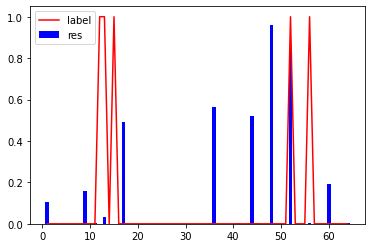

In [25]:
ix = 5
plot_test_res(test_res[ix], test_labels[ix])

In [6]:
data_cv = pd.read_csv('../Data/Chevy/chevy001.csv')
data_cv["bin"] = data_cv["Data"].apply(int, base=16).apply(bin).str[2:].apply(lambda x: x.zfill(64))

In [6]:
data_cd = pd.read_csv('../Data/Cadillac/001.txt.csv')